In [ ]:
from keras.models import load_model
import keraOverlay as overlay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt 
#import own libraries
import utils
import preproc

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data and masks as dicom files
data_dir = '../../data'                   #Please change the path accordingly before make any changes
normalNames = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

In [3]:
#Load preliminary trained model
model = load_model('Scale_down64.h5', custom_objects={'dice_coef_loss': overlay.dice_coef_loss,
                                                      'dice_coef': overlay.dice_coef})

In [13]:
#Load data names that is okay to use and add expand & shrink data
normal_namelist = []
aug_namelist = []
with open(normalNames) as f:
    content = f.readlines()
    normal_namelist = [x.strip() for x in content] 

for name in normal_namelist:
    name_base = name.split('.')[0]
    aug_namelist.append(name)
    #aug_namelist.append(name_base+'expand.dcm')
    #aug_namelist.append(name_base+'shrink.dcm')
#print(aug_namelist)

In [11]:

#Set Cross Validation parameters
#n_data = len(normal_namelist)  #define number of data to be used (use all data if len(normal_namelist)
n_data = 10
k = 5   #Number of folds
n_batch = 4 #Number of batches
data_name_list = normal_namelist[:n_data]
folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(np.array(data_name_list), np.zeros(n_data)))

In [ ]:

box_size=64
complete=False
toBoxes=True
#only_valid=False
#Training
epochs = 2
patience = None  #number of epochs that is tolerated if no improvement
sigma = 1.0   #Gaussian sigma parameter for smooth input image (not mask) before padding/scaling down
n_augment = 1
for index in range(k):
    print(index+1, "/", k, "fold")
    train_list = [data_name_list[i] for i in folds[index][0]]
    val_list = [data_name_list[i] for i in folds[index][1]]
    n_valid = int(len(train_list)/2)
    
    vbox_train_list = train_list[:n_valid]
    wbox_train_list = train_list[n_valid:]
    vbox_val_list = val_list[:n_valid]
    wbox_val_list = val_list[n_valid:]

    print(vbox_train_list)
    print(wbox_train_list)
    
#test the number of boxes!   
    train_box_no = []
    val_box_no = []
    # Half the data only use valid box
    for filename in vbox_train_list:
        print(vbox_train_list)
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=True)
        train_box_no.append(number)
    n_boxes_train = np.sum(np.array(train_box_no))
    print("box number in train set:", n_boxes_train, train_box_no)
    
    for filename in vbox_val_list:
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=True)
        val_box_no.append(number)
    n_boxes_val = np.sum(np.array(val_box_no))
    print("box number in val set:", n_boxes_val, val_box_no)
    
    history = model.fit_generator(overlay.generate_box_data(img_dir, msk_dir, vbox_train_list, batch_size=n_batch, only_valid=True), 
                                  epochs=1, verbose=1, steps_per_epoch=int(np.ceil(n_boxes_train/n_batch)), augment=True, n_augment=n_augment,
                                  validation_data=overlay.generate_box_data(img_dir, msk_dir, vbox_val_list, batch_size=1),
                                  validation_steps=n_boxes_val,
                                  callbacks=overlay.get_callbacks('box64.h5', early_stopping_patience=patience))
  
    
    train_box_no = []
    val_box_no = []
    # Half the data use all data
    for filename in wbox_train_list:
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=False)
        train_box_no.append(number)
    n_boxes_train = np.sum(np.array(train_box_no))
    print("box number in train set:", n_boxes_train, train_box_no)
    
    for filename in wbox_val_list:
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=True)
        val_box_no.append(number)
    n_boxes_val = np.sum(np.array(val_box_no))
    print("box number in val set:", n_boxes_val, val_box_no)
    
    
    #print(train_list, val_list)
    
    history = model.fit_generator(overlay.generate_box_data(img_dir, msk_dir, wbox_train_list, batch_size=n_batch, only_valid=False), 
                                  epochs=1, verbose=1, steps_per_epoch=int(np.ceil(n_boxes_train/n_batch)), augment=True, n_augment=n_augment,
                                  validation_data=overlay.generate_box_data(img_dir, msk_dir, wbox_val_list, batch_size=1),
                                  validation_steps=n_boxes_val,
                                  callbacks=overlay.get_callbacks('box64.h5', early_stopping_patience=patience))


1 / 5 fold
['A071.dcm', 'A030.dcm', 'A010.dcm', 'A073.dcm']
['A040.dcm', 'A027.dcm', 'A022.dcm', 'A066.dcm']
Error: unable to load data!


NameError: name 'sample' is not defined

In [8]:
#Load data
x_list, y_list = utils.load_data(img_dir, msk_dir, normal_namelist, sigma_image=0, sigma_mask=0, scaling=0, OPaslist=True)

In [26]:
#predict one data
n_slice = 64
size = 64
print(len(x_list))
index = 9
print(x_list[0].shape)
#data = utils.padImage([x_list[index]], size)
#mask = utils.padImage([y_list[index]], size)
n, data_boxes, mask_boxes = preproc.to3dpatches(x_list[index], y_list[index], depth = n_slice, size = n_slice, complete =True)
print(n)
prediction_box = []
for i in range(n):
    prediction_box.append(model.predict(data_boxes[i].reshape(1,n_slice,size,size,1), steps=1))


(1, 64, 64, 64, 1)
(256, 256, 256)
(220, 256, 256)
(220, 256, 256)


In [34]:
from imp import reload
reload(utils)
print(prediction_box[0].shape)
prediction = utils.stitch(np.squeeze(prediction_box), 4,4,4)
print(prediction.shape)
prediction = utils.unpadImage([prediction], 36)
print(prediction[0].shape)


(1, 64, 64, 64, 1)
(256, 256, 256)
(220, 256, 256)
(220, 256, 256)


(1, 64, 64, 64, 1)
(256, 256, 256)
(220, 256, 256)
(220, 256, 256)


In [42]:
from keras import backend

print(backend.floatx())
mask = utils.unpadImage([y_list[index]], 36)[0]

#dice = model_3d.dice_coef(predictions[0],x_list[index])
result = prediction[0]
dice = overlay.dice_coef(mask[np.newaxis, ...],result[np.newaxis, ...])
#dice = model_3d.dice_coef(backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64),backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64))
result[result>0.5] = 1
result[result<=0.5] = 0
#print(predictions[0][slice_index].dtype)
#dice = dice_coef(y_list[index],predictions[0])
print(dice)
#dice = backend.print_tensor(dice*8, message='y_pred = ')
#backend.print_tensor(dice, message='')
#print(dice)
#piece = predictions[0]
#piece = piece[piece > 0.9]
#dice = model_3d.dice_coef(piece,piece)
backend.eval(dice)

float32
(220, 256, 256)


Tensor("Mean_2:0", shape=(), dtype=float32)


0.011974428

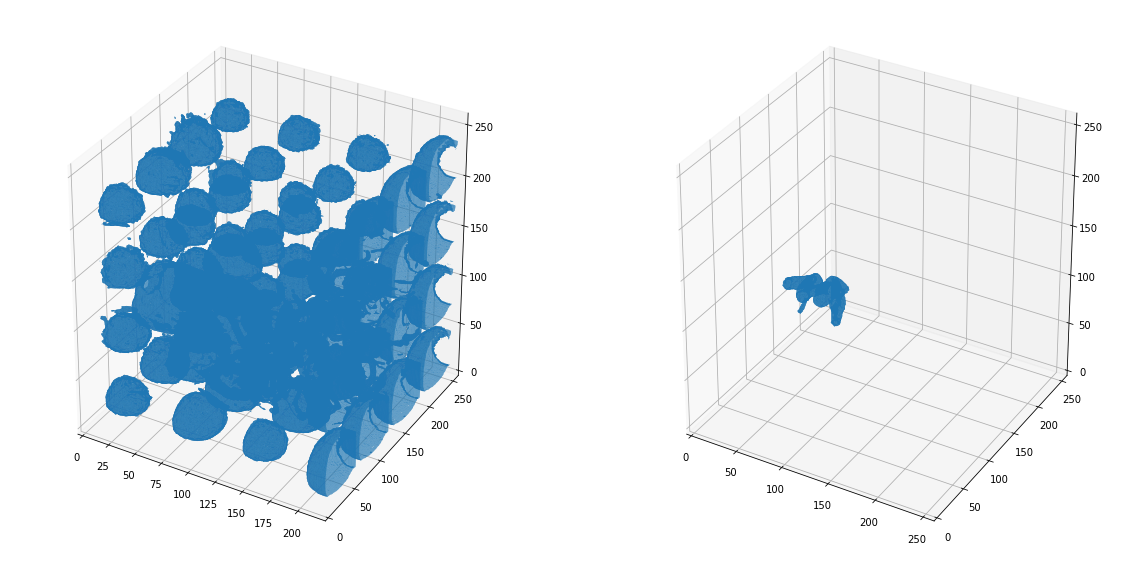

In [40]:
utils.plot_3d(result, y_list[index], threshold=0.5, threshold2=0.0)